# Car Resale Value Prediction Model

The dataset has been taken from Kaggle. This dataset contains Car resale prices all over the cities from India

### Data Description

- **full_name**: Name of the car along with model
- **resale_price**: Resale price of the car (in Rs)
- **registered_year**: Year the car was registered
- **engine_capacity**: Engine Displacement of car (cc)
- **insurance**: Type of insurance made available for the car (if any)
- **transmission_type**: Transmission type of the car
- **kms_driven**: Total kilometers the car was driven for
- **owner_type**: Number of owners who previously owned the car
- **fuel_type**: Type of fuel the car uses
- **max_power**: Maximum power of the car (bhp)
- **seats**: Number of seats the car has
- **mileage**: Mileage of the car(kmpl)
- **body_type**: Body configuration of the car
- **city**: City in India the car is sold in

### Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.model_selection import cross_val_score

import pickle

import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [2]:
df = pd.read_csv('car_resale_prices.csv' , index_col=0)
df.head()

,full_name,resale_price,registered_year,engine_capacity,insurance,transmission_type,kms_driven,owner_type,fuel_type,max_power,seats,mileage,body_type,city
0,2017 Maruti Baleno 1.2 Alpha,₹ 5.45 Lakh,2017,1197 cc,Third Party insurance,Manual,"40,000 Kms",First Owner,Petrol,83.1bhp,5.0,21.4 kmpl,Hatchback,Agra
1,2018 Tata Hexa XTA,₹ 10 Lakh,2018,2179 cc,Third Party insurance,Automatic,"70,000 Kms",First Owner,Diesel,153.86bhp,7.0,17.6 kmpl,MUV,Agra
2,2015 Maruti Swift Dzire VXI,₹ 4.50 Lakh,2015,1197 cc,Third Party insurance,Manual,"70,000 Kms",Second Owner,Petrol,83.14bhp,5.0,20.85 kmpl,Sedan,Agra
3,2015 Maruti Swift Dzire VXI,₹ 4.50 Lakh,2015,1197 cc,Third Party insurance,Manual,"70,000 Kms",Second Owner,Petrol,83.14bhp,5.0,20.85 kmpl,Sedan,Agra
4,2009 Hyundai i10 Magna 1.1,₹ 1.60 Lakh,2009,1086 cc,Third Party insurance,Manual,"80,000 Kms",First Owner,Petrol,68.05bhp,5.0,19.81 kmpl,Hatchback,Agra


### Shape of Dataframe

In [3]:
df.shape

(17446, 14)

### Null Values

In [4]:
df.isnull().sum()

full_name              0
resale_price           0
registered_year       69
engine_capacity       14
insurance              7
transmission_type      0
kms_driven             3
owner_type            45
fuel_type              0
max_power            102
seats                 10
mileage              508
body_type              0
city                   0
dtype: int64

### Description of Dataframe

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17446 entries, 0 to 17445
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   full_name          17446 non-null  object 
 1   resale_price       17446 non-null  object 
 2   registered_year    17377 non-null  object 
 3   engine_capacity    17432 non-null  object 
 4   insurance          17439 non-null  object 
 5   transmission_type  17446 non-null  object 
 6   kms_driven         17443 non-null  object 
 7   owner_type         17401 non-null  object 
 8   fuel_type          17446 non-null  object 
 9   max_power          17344 non-null  object 
 10  seats              17436 non-null  float64
 11  mileage            16938 non-null  object 
 12  body_type          17446 non-null  object 
 13  city               17446 non-null  object 
dtypes: float64(1), object(13)
memory usage: 2.0+ MB


## EDA

### Data Cleaning 

Converting resale_price, engine_capacity, kms_driven, max_power and mileage into float datatype

In [6]:
df['resale_price'] = df['resale_price'].str.replace('₹ ', '').str.replace(',', '')

def convert_price(value):
    if 'Lakh' in value:
        value = value.replace(' Lakh', '')
        return float(value) * 100000  
    elif 'Crore' in value:
        value = value.replace(' Crore', '')
        return float(value) * 10000000  
    else:
        return float(value)

df['resale_price'] = df['resale_price'].apply(convert_price)

In [7]:
df['engine_capacity'] = df['engine_capacity'].str.replace(' cc', '').astype(float)

In [8]:
df['kms_driven'] = df['kms_driven'].str.replace(',','').str.replace(' Kms', '').astype(float)

In [9]:
df = df[~df['max_power'].str.contains('at', case=False, na=False)]

df['max_power'] = df['max_power'].str.extract(r'(\d+\.?\d*)', expand=False).astype(float)

In [10]:
df = df[~df['mileage'].str.contains(' km/kg', case=False, na=False)]
df['mileage'] = df['mileage'].str.replace('kmpl', '').astype(float)

In [11]:
df['body_type'].value_counts()

body_type
Hatchback        7121
Sedan            4663
SUV              4397
MUV               727
Minivans           47
Maruti             15
Pickup             13
Coupe              10
Tata                7
Mercedes-Benz       6
Jaguar              3
Wagon               3
Chevrolet           3
Mahindra            3
Convertibles        2
Toyota              2
Cars                2
BMW                 2
Honda               2
Datsun              2
Audi                1
Porsche             1
Volvo               1
Hyundai             1
Skoda               1
Isuzu               1
Name: count, dtype: int64

Body type contains unnecessary values like(cars,Honada,Maruti etc.) so we will drop them.

In [12]:
df = df[~df['body_type'].isin(['Maruti', 'Tata','Mercedes-Benz','Chevrolet','Mahindra','Jaguar','BMW','Honda','Toyota','Cars','Datsun','Skoda','Audi','Hyundai','Volvo','Porsche','Isuzu'])]
df['body_type'].unique()

array(['Hatchback', 'MUV', 'Sedan', 'Minivans', 'SUV', 'Coupe', 'Pickup',
       'Convertibles', 'Wagon'], dtype=object)

In [13]:
df = df[~df['insurance'].isin(['1','2'])]
df['insurance'] = df['insurance'].str.replace('Third Party insurance', 'Third Party')
df['insurance'].unique()

array(['Third Party', 'Comprehensive', 'Zero Dep', 'Not Available', nan],
      dtype=object)

In [14]:
df["Company"] = df["full_name"].apply(lambda x : x.split()[1])
df["registered_year"] = df["full_name"].apply(lambda x : x.split()[0]).astype(int)
df = df.drop('full_name',axis = 1)
df.sample(5)

,resale_price,registered_year,engine_capacity,insurance,transmission_type,kms_driven,owner_type,fuel_type,max_power,seats,mileage,body_type,city,Company
16309,11200000.0,2020,2925.0,Comprehensive,Automatic,33000.0,First Owner,Diesel,325.86,7.0,NaN,SUV,Bangalore,Mercedes-Benz
2259,1425000.0,2019,1353.0,Comprehensive,Manual,16858.0,First Owner,Petrol,138.08,5.0,16.50,SUV,Jaipur,Kia
2222,575000.0,2017,1396.0,Comprehensive,Manual,81000.0,First Owner,Diesel,88.73,5.0,22.54,Hatchback,Jaipur,Hyundai
5847,640000.0,2019,1199.0,Comprehensive,Manual,22421.0,First Owner,Petrol,88.76,5.0,19.50,Sedan,Chennai,Honda
4572,784000.0,2019,1462.0,Third Party,Automatic,57033.0,First Owner,Petrol,103.25,5.0,20.28,Sedan,Ahmedabad,Maruti


### Handle Missing Values

In [15]:
df.replace("Not Available", np.nan, inplace=True)
df.isnull().sum()

resale_price           0
registered_year        0
engine_capacity       14
insurance            630
transmission_type      0
kms_driven             3
owner_type            43
fuel_type              0
max_power            101
seats                 10
mileage              499
body_type              0
city                   0
Company                0
dtype: int64

In [16]:
df['kms_driven'].fillna(df['kms_driven'].median(), inplace=True)
df['engine_capacity'].fillna(df['engine_capacity'].median(), inplace=True)
df['max_power'].fillna(df['max_power'].mean(), inplace=True)
df.dropna(subset=['insurance','seats','mileage','owner_type'], inplace=True)

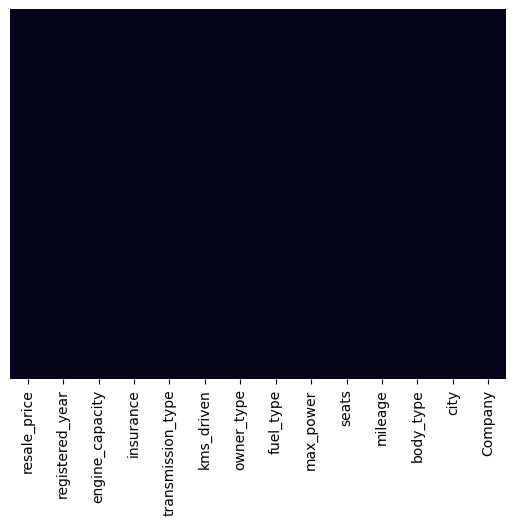

In [17]:
# Checking Null Values
sns.heatmap(df.isnull(),cbar=False,yticklabels=False)
plt.show()

In [18]:
df.sample(5)

,resale_price,registered_year,engine_capacity,insurance,transmission_type,kms_driven,owner_type,fuel_type,max_power,seats,mileage,body_type,city,Company
10052,385000.0,2017,998.0,Comprehensive,Manual,69359.0,First Owner,Petrol,67.04,5.0,23.10,Hatchback,Gurgaon,Maruti
7873,543000.0,2018,1197.0,Third Party,Manual,38953.0,Second Owner,Petrol,81.86,5.0,18.90,Hatchback,Hyderabad,Hyundai
7940,640000.0,2020,999.0,Third Party,Manual,30000.0,First Owner,Petrol,71.01,7.0,20.00,MUV,Hyderabad,Renault
1639,364000.0,2012,1461.0,Third Party,Manual,121243.0,Second Owner,Diesel,108.45,5.0,19.01,SUV,Jaipur,Renault
15214,590000.0,2019,1186.0,Third Party,Manual,110000.0,First Owner,Diesel,73.97,5.0,24.00,Hatchback,Delhi,Hyundai


### Data Visualization

In [19]:
# Seperating Numerical and Categorical features
categorical = ['insurance','transmission_type','owner_type','fuel_type','body_type','city','Company']
numerical = df.drop(categorical,axis=1)

#### Numerical Features

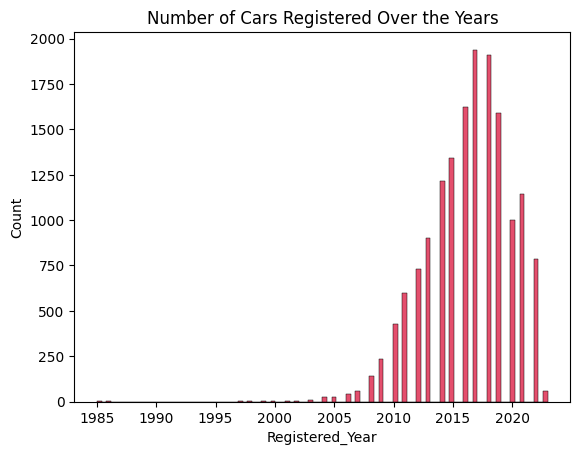

In [20]:
sns.histplot(x=df['registered_year'],color='Crimson')
plt.title('Number of Cars Registered Over the Years')
plt.xlabel('Registered_Year')
plt.ylabel('Count')
plt.show()

People in India started buying cars in early 2000s and the number of cars registered each year continued to rise, reaching its peak around 2015-2019. There is a decline around 2020, one of the reason for this could be pandemic.  

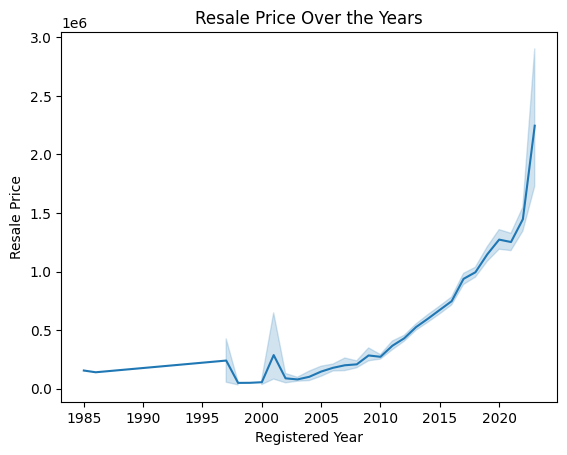

In [21]:
sns.lineplot(x=df['registered_year'], y=df['resale_price'])
plt.title('Resale Price Over the Years')
plt.xlabel('Registered Year')
plt.ylabel('Resale Price')
plt.show()

The cars registered way back in 2000s have leass resale value then the cars bought in recent years which is quite predictible.

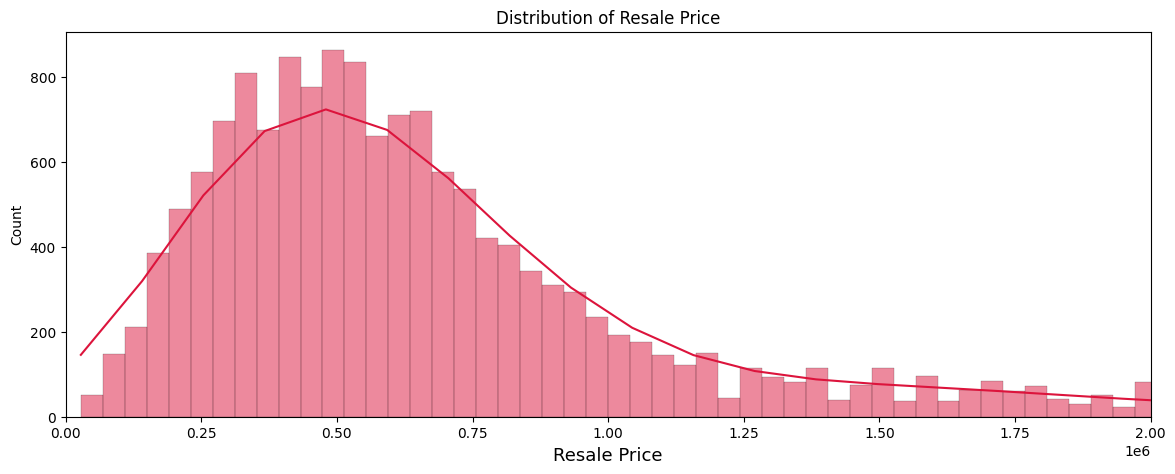

In [22]:
plt.figure(figsize=(14,5))
sns.histplot(x=df['resale_price'],kde=True,color='Crimson')
plt.xlabel('Resale Price',fontsize=13)
plt.xlim(0,2e6)
plt.title('Distribution of Resale Price')
plt.show()

Text(0.5, 1.0, 'Correlational Heatmap')

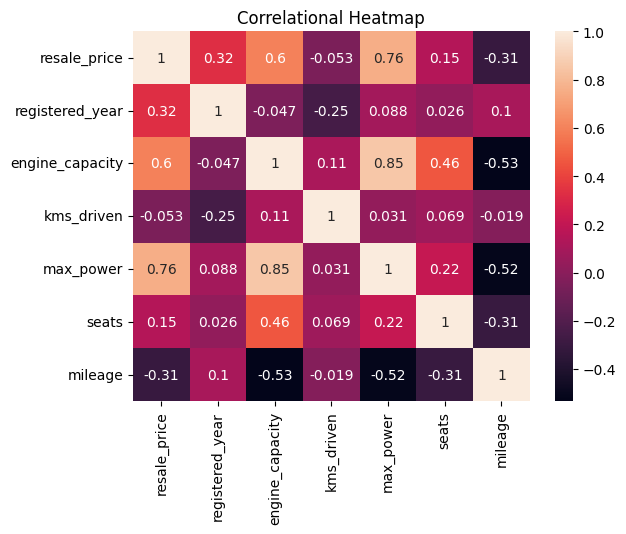

In [23]:
sns.heatmap(numerical.corr(),annot=True) 
plt.title('Correlational Heatmap')

### Categorical Features

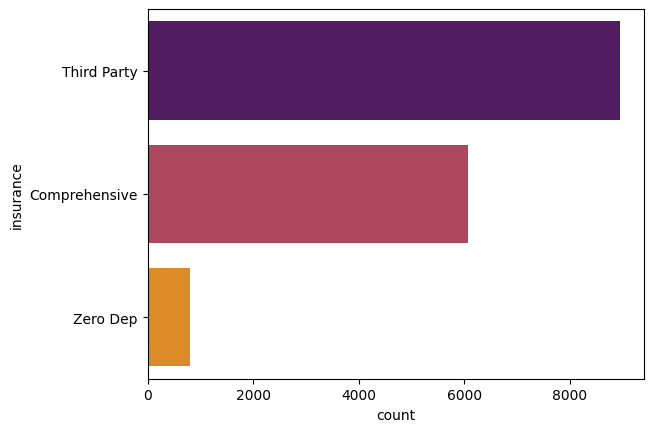

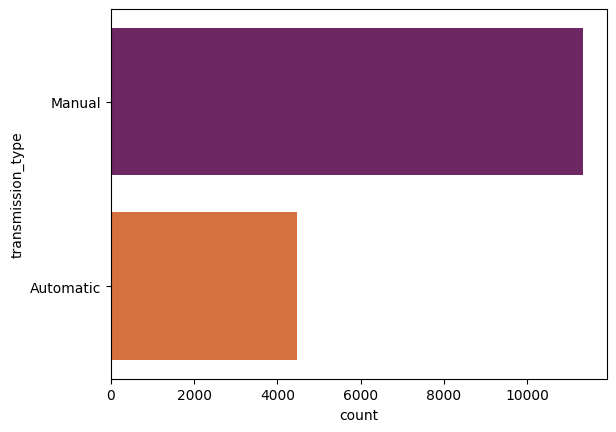

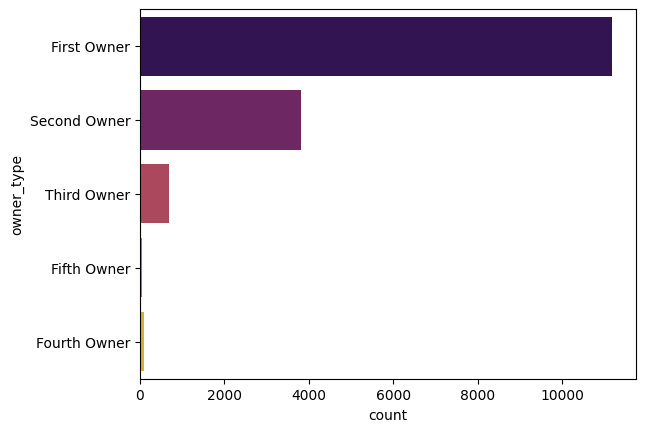

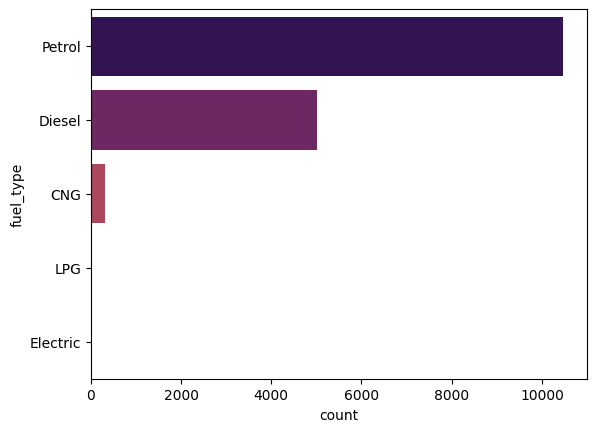

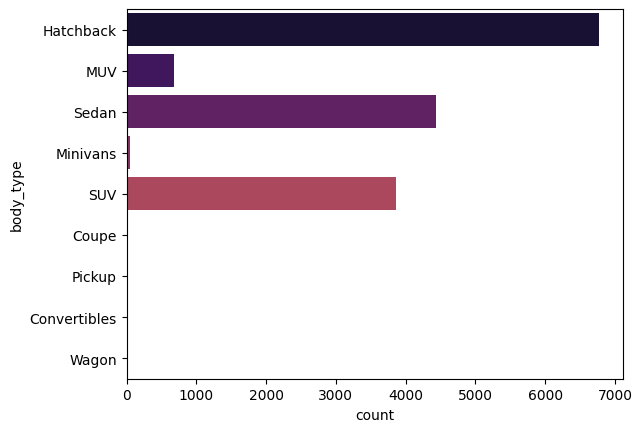

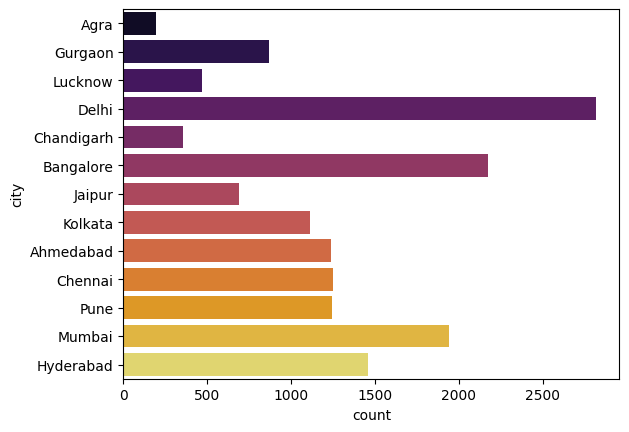

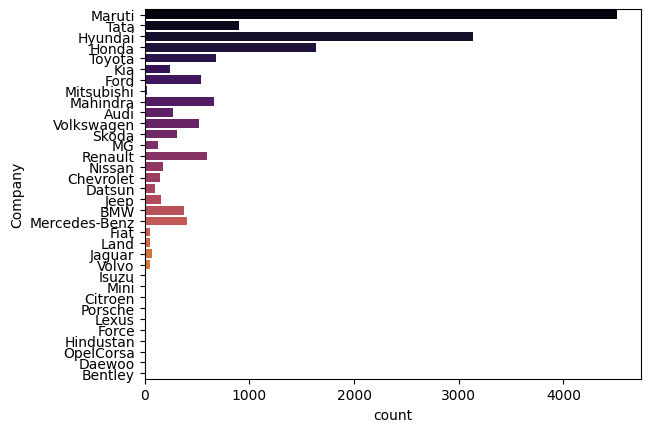

In [24]:
for features in categorical:
    sns.countplot(df[features],palette='inferno')
    plt.xlabel('count')
    plt.ylabel(features)
    plt.show()

#### Below graphs show the Variation in Resale Price due to different types of insurance,Companies,Transmission and many other features

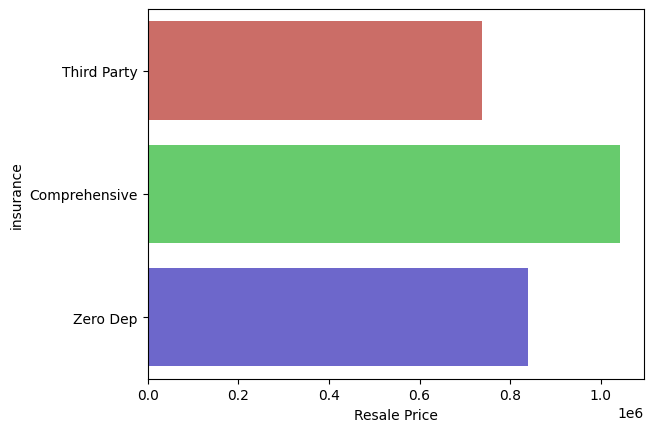

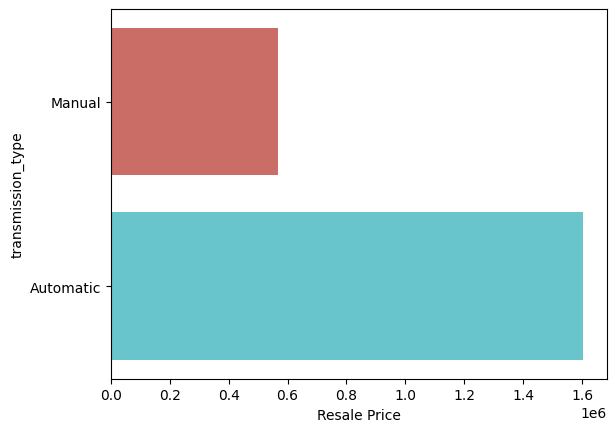

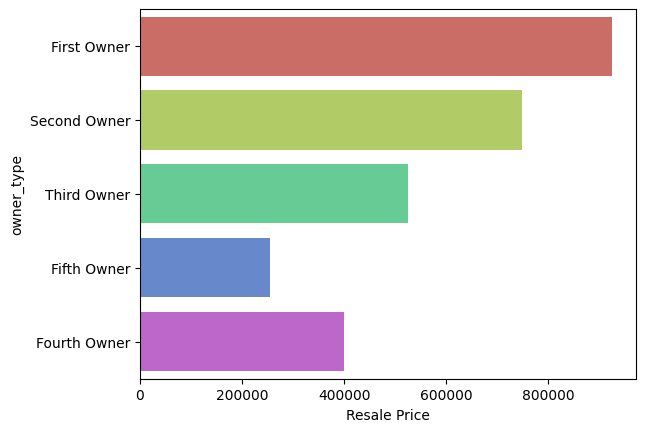

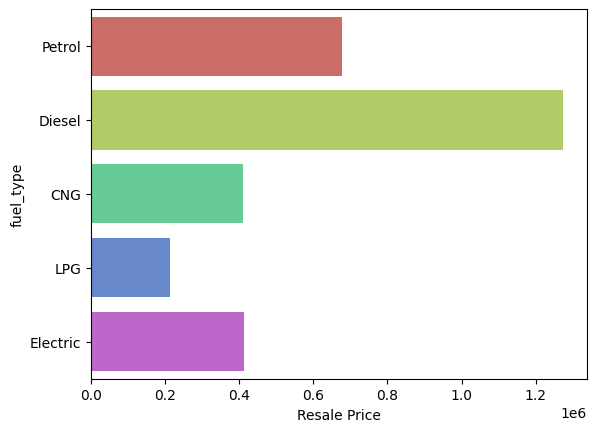

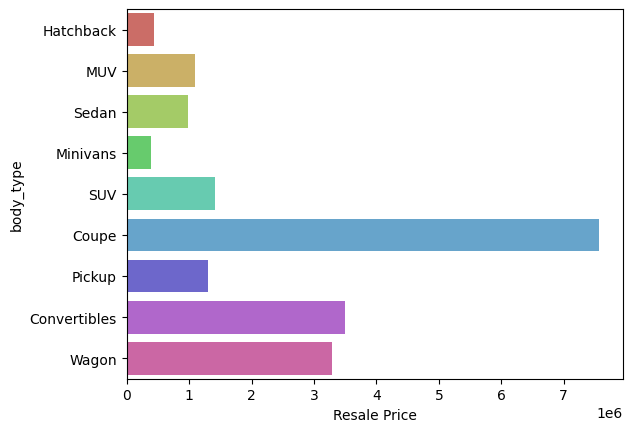

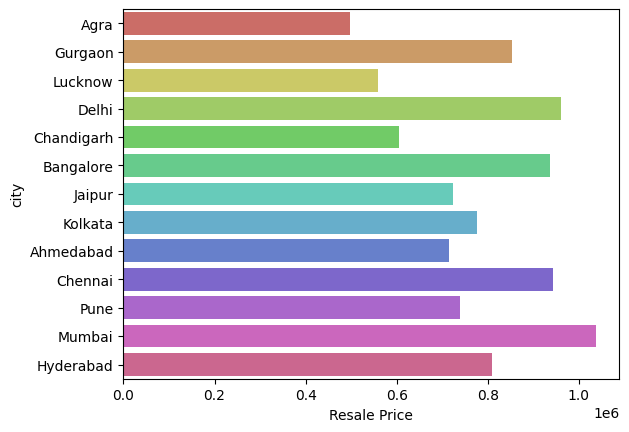

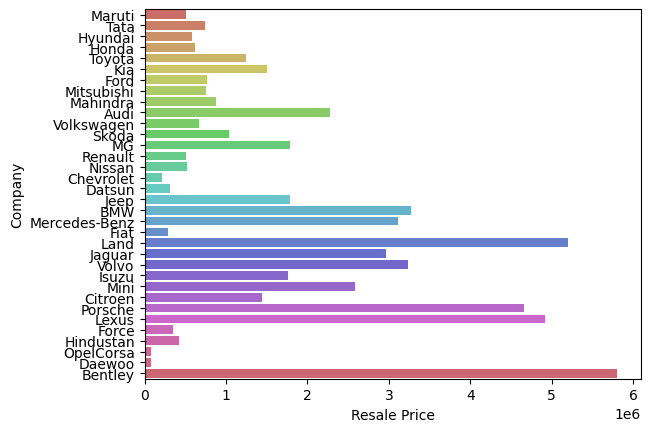

In [25]:
for features in categorical:
    sns.barplot(x=df['resale_price'],y=df[features],palette='hls',errorbar=None)
    plt.xlabel('Resale Price')
    plt.ylabel(features)
    plt.show()

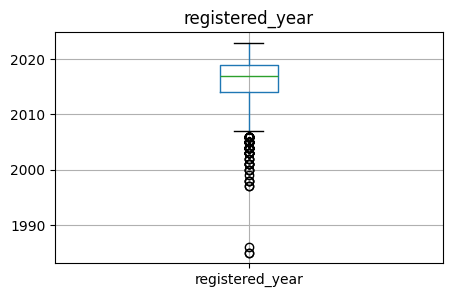

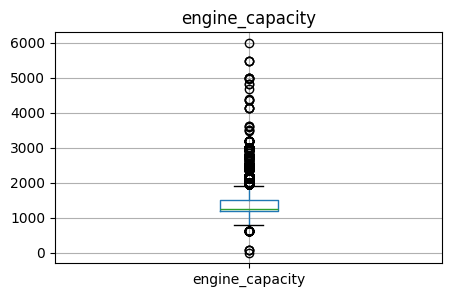

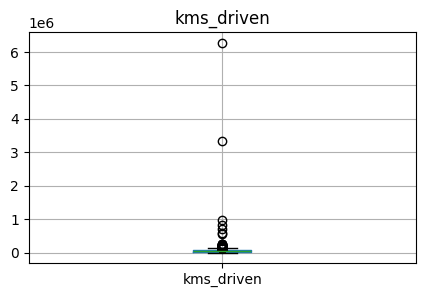

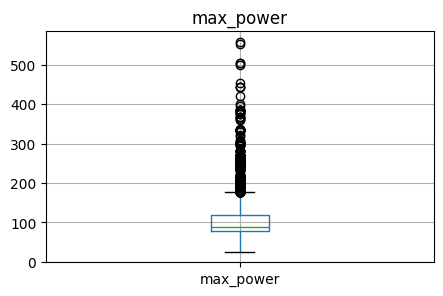

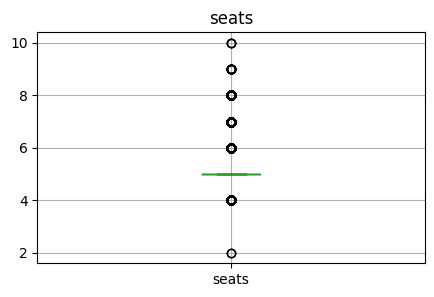

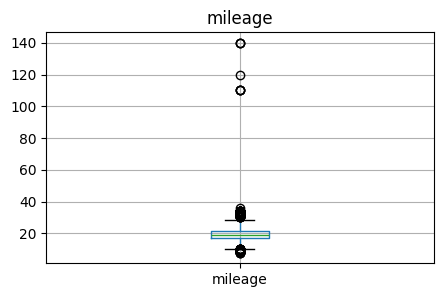

In [26]:
# Ouliers Visualization
for feature in numerical:
    if feature != 'resale_price':
        plt.figure(figsize=(5,3))
        df.boxplot(column=feature)
        # plt.ylabel(feature)
        plt.title(feature)
        plt.show()

## Applying One-Hot-Encoding

In [27]:
df=pd.get_dummies(df,columns=categorical,dtype=int)
df.shape

(15814, 78)

In [28]:
df.sample(5)

,resale_price,registered_year,engine_capacity,kms_driven,max_power,seats,mileage,insurance_Comprehensive,insurance_Third Party,insurance_Zero Dep,...,Company_Mitsubishi,Company_Nissan,Company_OpelCorsa,Company_Porsche,Company_Renault,Company_Skoda,Company_Tata,Company_Toyota,Company_Volkswagen,Company_Volvo
3814,391000.0,2014,1198.0,75029.0,86.80,5.0,19.40,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16276,330000.0,2012,1248.0,41000.0,75.00,5.0,20.30,1,0,0,...,0,0,0,0,0,0,0,0,0,0
12834,581000.0,2018,1197.0,26000.0,81.80,5.0,21.21,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3808,354000.0,2014,998.0,66783.0,67.04,5.0,20.51,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6769,1365000.0,2019,1999.0,64882.0,149.92,5.0,14.62,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Spliting the Data

In [29]:
X = df.drop('resale_price',axis=1)
Y = df['resale_price']

X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100)

In [30]:
print("X_train:", X_train.shape)
print("X_test:",X_test.shape)
print("Y_train:",Y_train.shape) 
print("Y_test:",Y_test.shape)

X_train: (12651, 77)
X_test: (3163, 77)
Y_train: (12651,)
Y_test: (3163,)


## Training Models

### Linear Regression

In [31]:
# Training The Linear Regression Model
model1 = LinearRegression()
model1.fit(X_train, Y_train)

LinearRegression()

In [32]:
# Making Prediction For Test Dataset
Y_pred = model1.predict(X_test)

In [33]:
# Predicting Accuracy of Model
print(model1.score(X_test,Y_test))

0.6892398009560106


In [34]:
CV1 = cross_val_score(model1,X_train,Y_train,cv=5)
print(CV1)

[0.75201074 0.70173496 0.72728641 0.68696209 0.72842624]


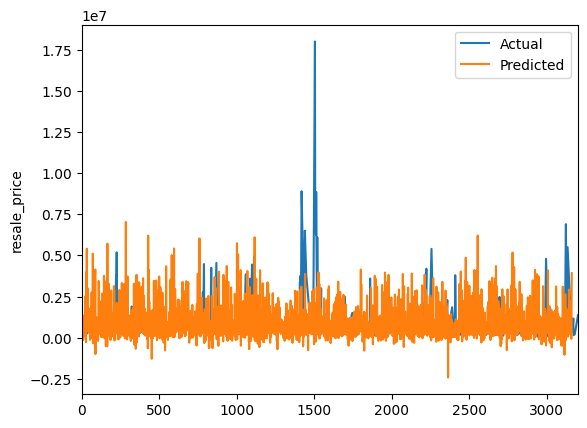

In [35]:
# Visualization of performance
sns.lineplot(Y_test, label='Actual')
sns.lineplot(Y_pred, label='Predicted')
plt.xlim(0,3200)
plt.legend()
plt.show()

### XGBoost

In [36]:
model2= xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model2.fit(X_train, Y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [37]:
Y_predt = model2.predict(X_test)

In [38]:
print(model2.score(X_test,Y_test))

0.9119535343358782


In [39]:
CV2 = cross_val_score(model2,X_train,Y_train,cv=5)
print(CV2)

[0.91615065 0.9303113  0.92667094 0.86802516 0.9339211 ]


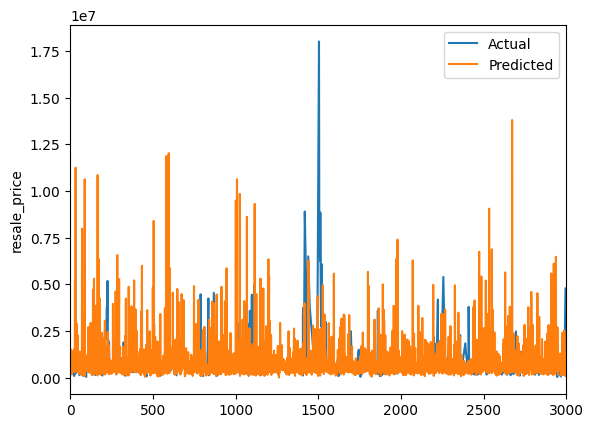

In [40]:
# Visualization of performance
sns.lineplot(Y_test, label='Actual')
sns.lineplot(Y_predt, label='Predicted')
plt.xlim(0,3000)
plt.legend()
plt.show()

### Random Forest

In [41]:
model3 = RandomForestRegressor(n_estimators=100, random_state=42)
model3.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [42]:
Y_predict = model3.predict(X_test)

In [43]:
print(model3.score(X_test,Y_test))

0.9304791455918067


In [44]:
CV3 = cross_val_score(model3,X_train,Y_train,cv=5)
print(CV3)

[0.91885418 0.91909888 0.92889428 0.85952425 0.92611108]


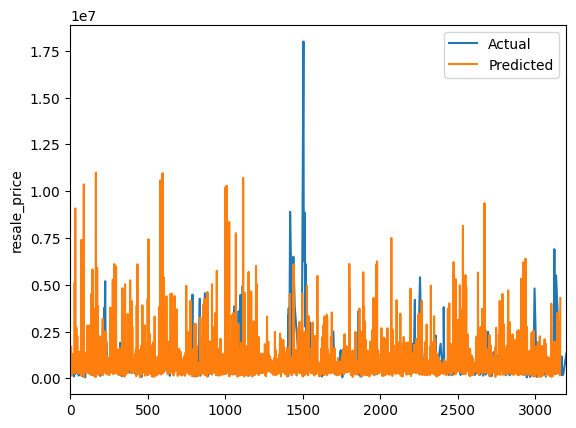

In [45]:
# Visualization of performance
sns.lineplot(Y_test, label='Actual')
sns.lineplot(Y_predict, label='Predicted')
plt.xlim(0,3200)
plt.legend()
plt.show()

### Saving The Best Model

In [46]:
import gzip
with gzip.open('car_resale_model.pkl.gz ', 'wb') as file:
    pickle.dump(model3, file)

## Conclusion

After Training and Evaluating all the models below are the results :
- **Random Forest** and **XGBoost** significantly outperform **Linear Regression**
- The small difference in accuracy between Random Forest and XGBoost suggests that both models are well-suited for this dataset, but Random Forest has a slight edge in performance.


## Thank You For Reading